In [1]:
import json
from operator import itemgetter
from pyspark.sql import functions as fun
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
plt.style.use("ggplot")

In [2]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
import matplotlib as mpl
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import HoverTool
output_notebook()

Loading BokehJS ...

In [3]:
!hdfs dfs -cat /ix/ml-20m/genome-scores.txt  | tail -n 2

{"relevance": 0.11449999999999999, "tagId": 1127, "movieId": 131170}
{"relevance": 0.02174999999999999, "tagId": 1128, "movieId": 131170}


In [4]:
gen_tag= sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
gentag = dict(gen_tag.map(itemgetter("tagId", "tag")).collect())

In [5]:
gen_score= sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)

In [6]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)

In [7]:
genscore_DF = gen_score.toDF(['movieId', 'relevance', 'tagId'])# transform gen score file into a dataset

/usr/hdp/current/spark-client/python/pyspark/sql/context.py:259: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


We want to Construct an M ×N data matrix, where M is the number of tags and N the number of movies. So let's group the movies by ID.

In [8]:
gen_groups = genscore_DF.groupBy('movieId').agg(fun.collect_list('relevance'), fun.collect_list('tagId'))

In [9]:
gen_groups_collect = gen_groups.collect()
MN_matrix = np.zeros( (len(gentag), len(gen_groups_collect)) ) 
MN_matrix.shape#We check the size of the MxN matrix

(1128, 10381)

We can see that for each movie, we get the relevance associated with each tag. Now we need to build the matrix from this. 

In [10]:
gen_groups_collect[0]

Row(movieId=31, collect_list(relevance)=[0.04099999999999998, 0.05125000000000002, 0.020500000000000018, 0.032999999999999974, 0.09225, 0.11125000000000002, 0.027000000000000024, 0.11299999999999999, 0.07524999999999998, 0.017249999999999988, 0.025749999999999995, 0.035499999999999976, 0.19574999999999998, 0.008500000000000008, 0.0027499999999999747, 0.026249999999999996, 0.016500000000000015, 0.118, 0.17125, 0.15825, 0.36524999999999996, 0.248, 0.11225000000000002, 0.05449999999999999, 0.14100000000000001, 0.16725, 0.05275000000000002, 0.044499999999999984, 0.1795, 0.062, 0.008000000000000007, 0.02350000000000002, 0.0605, 0.031000000000000028, 0.035750000000000004, 0.09375, 0.0695, 0.02150000000000002, 0.014249999999999985, 0.007249999999999979, 0.03949999999999998, 0.049750000000000016, 0.07200000000000001, 0.07850000000000001, 0.058750000000000024, 0.13624999999999998, 0.007500000000000007, 0.2945, 0.18874999999999997, 0.09775, 0.16899999999999998, 0.11775000000000002, 0.02975, 0.08

So we just need to run through all tags and movies IDs and match the corresponding relevance score.

In [11]:
id_list=[]
for index, data in enumerate(gen_groups_collect):
    Id = data[0]
    score = data[1]
    tags = data[2]
    
    id_list.append(Id)
    
    for rel, tag in zip(score, tags):
        MN_matrix[tag-1, index] = rel
   

In [12]:
MN_matrix

array([[ 0.041  ,  0.04425,  0.027  , ...,  0.01825,  0.0385 ,  0.068  ],
       [ 0.05125,  0.04825,  0.02725, ...,  0.024  ,  0.03875,  0.08525],
       [ 0.0205 ,  0.01925,  0.01975, ...,  0.076  ,  0.024  ,  0.0215 ],
       ..., 
       [ 0.01225,  0.0115 ,  0.01125, ...,  0.01125,  0.0175 ,  0.009  ],
       [ 0.08025,  0.07825,  0.07225, ...,  0.076  ,  0.16825,  0.96475],
       [ 0.01675,  0.01425,  0.01825, ...,  0.01825,  0.0275 ,  0.93775]])

We can eventually convert this matrix into a panda dataframe.

In [13]:
df=pd.DataFrame(MN_matrix)

In [14]:
df.index.name='Movies ID'
df=df.rename_axis("Tags", axis="columns")

In [15]:
df.axes

[RangeIndex(start=0, stop=1128, step=1, name='Movies ID'),
 RangeIndex(start=0, stop=10381, step=1, name='Tags')]

In [16]:
df.head()

Tags,0,1,2,3,4,5,6,7,8,9,...,10371,10372,10373,10374,10375,10376,10377,10378,10379,10380
Movies ID,,,,,,,,,,,,,,,,,,,,,
0,0.04100,0.04425,0.02700,0.03725,0.02625,0.03600,0.03850,0.05500,0.05825,0.06575,...,0.14525,0.03075,0.02700,0.07900,0.03000,0.0240,0.3985,0.01825,0.03850,0.06800
1,0.05125,0.04825,0.02725,0.04350,0.03200,0.04050,0.04250,0.06350,0.05975,0.06325,...,0.05950,0.02850,0.02775,0.04225,0.02975,0.0225,0.9140,0.02400,0.03875,0.08525
2,0.02050,0.01925,0.01975,0.02850,0.03075,0.13025,0.21425,0.03200,0.03150,0.02500,...,0.01625,0.02100,0.02100,0.02100,0.03000,0.0315,0.0295,0.07600,0.02400,0.02150
3,0.03300,0.06725,0.10300,0.03000,0.04250,0.09000,0.20075,0.05875,0.06075,0.02925,...,0.01750,0.03700,0.02775,0.03775,0.04900,0.0565,0.0475,0.06900,0.03300,0.04400
4,0.09225,0.10200,0.18875,0.04200,0.11875,0.13825,0.19925,0.08075,0.09200,0.05425,...,0.02850,0.05275,0.06150,0.06125,0.07525,0.1100,0.0660,0.11150,0.10450,0.06200


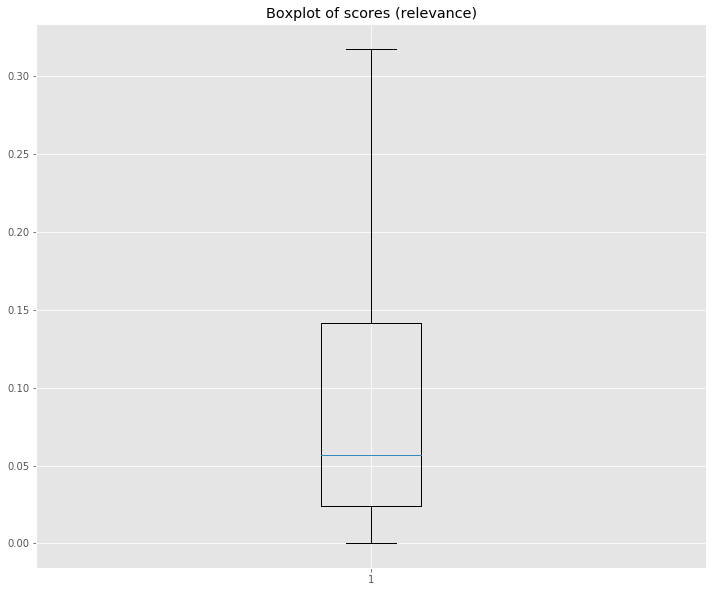

In [17]:
plt.figure(figsize=(12,10))
plt.boxplot(df.values.flatten(),0, '')
plt.title('Boxplot of scores (relevance)')
plt.show()

We notice that the median is around 5% relevance.

In [18]:
variance_tag=df.var(axis=0)

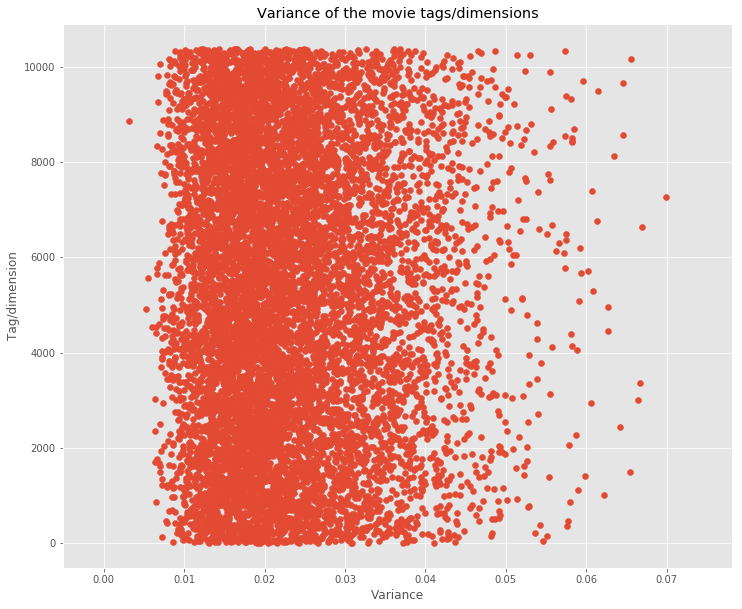

In [19]:
plt.figure(figsize=(12,10))
plt.scatter(variance_tag, range(1, len(variance_tag)+1))
plt.title("Variance of the movie tags/dimensions")
plt.ylabel('Tag/dimension')
plt.xlabel('Variance')
plt.show()

We notice that variance is quite small for all dimensions which could suggets that movies with same tags have close scores.

In [20]:
# covariance matrix of M
MN_matrix_centered = MN_matrix - np.array([np.mean(MN_matrix, axis=1)]).T
M_cov = np.cov(MN_matrix_centered)
M_cov

array([[ 0.00490042,  0.00327346, -0.00030115, ...,  0.00016838,
        -0.00016172, -0.00014599],
       [ 0.00327346,  0.00374098, -0.00023234, ...,  0.00011866,
        -0.00015645, -0.00014514],
       [-0.00030115, -0.00023234,  0.01184989, ...,  0.00130349,
        -0.00112118, -0.00035662],
       ..., 
       [ 0.00016838,  0.00011866,  0.00130349, ...,  0.0188282 ,
        -0.00114338, -0.00032847],
       [-0.00016172, -0.00015645, -0.00112118, ..., -0.00114338,
         0.01105378,  0.00659333],
       [-0.00014599, -0.00014514, -0.00035662, ..., -0.00032847,
         0.00659333,  0.00658031]])

In [21]:
eigvalues, eigvectors = np.linalg.eigh(M_cov)

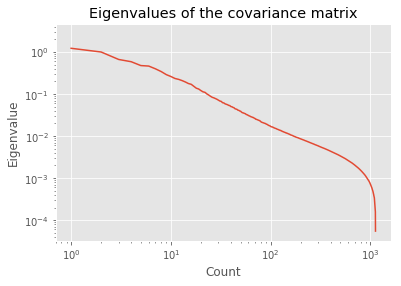

In [22]:

eigvalues_list = eigvalues.tolist()

eigvalues_list.reverse()# to ger in descending order

plt.loglog(eigvalues_list)
plt.title("Eigenvalues of the covariance matrix")
plt.ylabel('Eigenvalue')
plt.xlabel('Count')
plt.show()

Eigenvalues are mostly small

In [23]:
cum = (np.cumsum(eigvalues_list) / np.sum(eigvalues))

princ_compo = [ n for n,i in enumerate(cum) if i>((2./3) ) ][0]
princ_compo

36

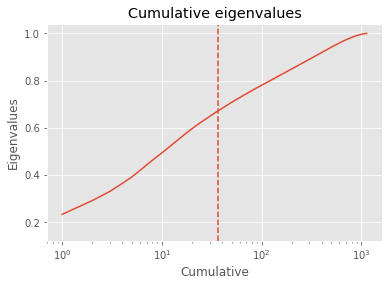

In [24]:
plt.semilogx(cum)
plt.title("Cumulative eigenvalues")
plt.ylabel('Eigenvalues')
plt.xlabel('Cumulative')
plt.axvline(princ_compo, linestyle='dashed')
plt.show()

In [25]:
eigen_five = eigvalues_list[:5]
eigen_five#five largest eigenvalues

[2.7533774797813497,
 1.2214710425886668,
 0.9960515193084873,
 0.662175500207405,
 0.5857297851139419]

In [26]:
for i in range(5):  
    return_index = np.argsort(eigvectors[:, -(i+1)])
    print('\n Eigenvector N°{}\n'.format(i+1))
    print('Highest 10 vs. lowest 10')
    for highest, lowest in zip(return_index[-10:][::-1], return_index[:10]):
        print("{: >20} {: >20}".format(gentag[highest], gentag[lowest]))


 Eigenvector N°1

Highest 10 vs. lowest 10
     talking animals      powerful ending
              soccer               snakes
     crime gone awry           bad ending
         imagination               silent
               great                silly
             dragons            hong kong
oscar (best cinematography)               france
      blaxploitation             kurosawa
               drama             biblical
                 cia            colourful

 Eigenvector N°2

Highest 10 vs. lowest 10
 interracial romance               absurd
          reflective              special
     crime gone awry             biblical
          meditative      character study
           lone hero              fashion
                 god             survival
            medieval          good acting
                 art      pixar animation
         melancholic                   pg
          sex comedy               action

 Eigenvector N°3

Highest 10 vs. lowest 10
     feel good movie 

Let's project in our new feature space: We first define the eigenspace of the 5 highest eigenvalues and then project the matrix normalized onto this new reduced space.

In [27]:
eigen_space = np.dot(eigvectors[:,-5:].T, MN_matrix_centered)#dot product = projection
projection = np.dot(MN_matrix_centered, eigen_space.T)

In [28]:
tag_mapping = {}

for key, value in tag_mapping.items():
    tag_mapping[value] = projection[key-1,:]

In [29]:
with open('projection_on_5.pickle', 'wb') as handle:
    pickle.dump(projection, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
with open('tag_mapping.pickle', 'wb') as handle:
    pickle.dump(tag_mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
with open('selected-movies.pickle', 'rb') as handle:
    selected_movies = pickle.load(handle, encoding='utf-8') 

In [32]:
selected_movies
#len(selected_movies)

((780, 'Independence Day (a.k.a. ID4) (1996)', 0.6),
 (5349, 'Spider-Man (2002)', 0.89),
 (2571, 'Matrix, The (1999)', 0.87),
 (318, 'Shawshank Redemption, The (1994)', 0.91),
 (2329, 'American History X (1998)', 0.83),
 (5147, 'Wild Strawberries (Smultronstället) (1957)', 0.95),
 (55444, 'Control (2007)', 0.87),
 (32296, 'Miss Congeniality 2: Armed and Fabulous (2005)', 0.15),
 (43930, 'Just My Luck (2006)', 0.13),
 (4658, 'Santa Sangre (1989)', 0.85),
 (6774, 'Videodrome (1983)', 0.78),
 (3967, 'Billy Elliot (2000)', 0.85),
 (114028, 'Pride (2014)', 0.92),
 (480, 'Jurassic Park (1993)', 0.93),
 (260, 'Star Wars: Episode IV - A New Hope (1977)', 0.93),
 (4700, 'Princess Diaries, The (2001)', 0.47),
 (527, "Schindler's List (1993)", 0.96),
 (2959, 'Fight Club (1999)', 0.79),
 (6132, 'New York Ripper, The (Squartatore di New York, Lo) (1982)', 0.17),
 (2858, 'American Beauty (1999)', 0.88),
 (6016, 'City of God (Cidade de Deus) (2002)', 0.9),
 (94018, 'Battleship (2012)', 0.34),
 (5687,

We need to retrieve those 37 movies in our matrix :

In [33]:
items_idx=[]
titles=[]
score=[]
for items in selected_movies:
    items_idx.append(items[0])
    titles.append(items[1])
    score.append(items[2])
    
selec=[id_list.index(i) for i in items_idx]
selected_MN_matrix= MN_matrix[:,selec] 
selected_MN_matrix.shape

(1128, 37)

Now we project on two first PC :

In [34]:
projected = eigvectors[:,-2:].T.dot(selected_MN_matrix)
projected.shape

(2, 37)

In [35]:
list(projected[0,:])

[-7.0046513222986491,
 -6.5683617061531621,
 -8.2887568693410039,
 -5.8469793586820673,
 -4.8791047963082281,
 -1.0961272811702374,
 -1.8150512541562513,
 -2.289430325011641,
 -1.8303448652081351,
 -1.8601570872829556,
 -1.8528059086619553,
 -2.2201140873897707,
 -1.8469216704740599,
 -7.2830296890243877,
 -7.5765829630719495,
 -2.3009949401115444,
 -4.7959914505868504,
 -5.6612924521251822,
 -2.9951092439009392,
 -3.1185938681355037,
 -4.3229104551686204,
 -4.9514078492758031,
 0.21770525613205866,
 -7.4443494654948097,
 -7.0766292577588148,
 -5.0294625397007291,
 -3.7401245085837171,
 -3.5359042615520382,
 -2.8265967275157284,
 -2.5413593613637526,
 -3.2403711678747062,
 -2.8005467589011435,
 -3.4826050275184897,
 -3.808230047148002,
 -3.7229820948022012,
 -2.7906872889413754,
 -3.6432593003081397]

In [ ]:
type(np.array(colors))

In [40]:

output_notebook()


output_file("selected_ratings.html")

source = ColumnDataSource(
        data=dict(
            x=projected[0,:],
            y=projected[1,:],
            title=titles ,
            score=score
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("Name", "@desc"),
            ("Rating", "@score"),
        ]
    )

p = figure(plot_width=500, plot_height=500, tools=[hover],
           title="Movie visualization of selected movies")
p.xaxis.axis_label = 'First Principal Component'
p.yaxis.axis_label = 'Second Principal Component'

p.circle('x', 'y', fill_alpha=0.2, size=10, source=source)

show(p)

Loading BokehJS ...